# Test Modles to English Data

In [1]:
# Add option to read from padded or to rerun it again.
# =============================================================================
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import os,errno
from time import time
import keras
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout,LSTM, Lambda,Bidirectional,GRU,Dense
from keras.callbacks import ModelCheckpoint,TensorBoard#,TimeDistributed
#from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as K
import sys
from preprocessing import restore
import tensorflow as tf
import random as rn
import re
# =============================================================================


Using TensorFlow backend.


In [2]:
# =======================Program Parameters====================================
load_weights_flag = 1
# 0-> last wait | 1 max val_acc
last_or_max_val_acc = 0

Experiement_Name = 'Experiment47'
layer_number = 3
#if u need one number for all layers add number alone
n_units = [200]
# 1->LSTM  , 2->GRU , 3->Bi-LSTM 
cell_mode = 2
drop_out_rate = 0.1
test_size_param=0.1
validation_split_param = 0.1
batch_size_param = 64
# 0 -> for test mode , 1 -> for train mode
learning_mode = 1

epochs_param = 5
#num of epoch should be wait when monitor don't change
earlystopping_patience=-1  

seed = 7


In [168]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)


# =========================Functions ==========================================
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
# =============================================================================

In [3]:
#===============================Concatinated Variables ========================
checkpoints_path ="../Experiement/checkpoints/"+Experiement_Name+"/"
check_points_file_path = checkpoints_path+ "/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
board_log_dir="../Experiement/logs/"+Experiement_Name+"/"#+.format(time())

try:
    os.makedirs(board_log_dir)
    os.makedirs(checkpoints_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        print("Can't create file for checkpoints or for logs please check ")
        raise

In [4]:
# =========================Data Loading========================================
X = restore("../data/new_downsample_merged_data_matrix_X_one_hot_encoding.h5","X")
Y = restore("../data/new_downsample_merged_data_matrix_Y_one_hot_encoding.h5","Y")
# X =X[0:100]
# Y =Y[0:100]
max_Bayt_length=X.shape[1]
char_dimension=X.shape[2]
numbber_of_bohor=Y.shape[1]
# =============================================================================


# ==============================Split Data=====================================
X_train, X_test, Y_train, Y_test=train_test_split(X, #bayts
                                                  Y, #classes
                                                  test_size=test_size_param, 
                                                  random_state=0)
# =============================================================================

In [5]:
X_train.shape

(15968, 78, 28)

In [12]:
# =========================RNN models ================================
# create model
K.set_learning_phase(learning_mode) #set learning phase

model = Sequential()

# add layers
for n in range(layer_number):
    if len(n_units)==1 and layer_number>1:
        i=0
    else:
        if len(n_units)>=1 and len(n_units) != layer_number:
            sys.exit("pleas make length of n_units == layer_number or add only one element in n_units ")
        i=n
    # check if LSTM 
    if cell_mode==1:
        #check if first layer to add input_shape
        if n==0:
            # if NN as only one layer so shuld remove retun_sequences
            if layer_number == 1:
                model.add(LSTM(n_units[i],input_shape=(max_Bayt_length,char_dimension)))
            # if NN has many layers so should add return_sequences
            else:
                model.add(LSTM(n_units[i], return_sequences=True,input_shape=(max_Bayt_length,char_dimension)))
        # if it's not the first layer
        else:
            #check if last layer
            if layer_number-1 == n:
                model.add(LSTM(n_units[i]))
            else:
                model.add(LSTM(n_units[i], return_sequences=True))

    #check if GRU    
    elif cell_mode==2:

        #check if first layer to add input_shape
        if n==0:
            if layer_number  == 1:
            # if NN as only one layer so shuld remove retun_sequences
                model.add(GRU(n_units[i],input_shape=(max_Bayt_length,char_dimension)))
            # if NN has many layers so should add return_sequences
            else:
                model.add(GRU(n_units[i], return_sequences=True,input_shape=(max_Bayt_length,char_dimension)))
        # if it's not the first layer
        else:
            #check if last layer
            if layer_number-1 == n:
                model.add(GRU(n_units[i]))
            else:
                model.add(GRU(n_units[i], return_sequences=True))        
    #check if Bi-LSTM
    else:
        #check if first layer to add input_shape
        if n==0:
            # if NN as only one layer so shuld remove retun_sequences
            if layer_number  == 1:
                model.add(Bidirectional(LSTM(n_units[i]),
                                        input_shape=(max_Bayt_length, char_dimension)))
            # if NN has many layers so should add return_sequences
            else:
                model.add(Bidirectional(LSTM(n_units[i], return_sequences=True),
                                        input_shape=(max_Bayt_length, char_dimension)))
        # if it's not the first layer
        else:
            #check if last layer
            if layer_number-1 == n:
                model.add(Bidirectional(LSTM(n_units[i])))
            else:
                model.add(Bidirectional(LSTM(n_units[i], return_sequences=True)))
    #check if there Dopout or not
    if drop_out_rate != 0:
        model.add(Dropout(drop_out_rate,seed=seed))

                      
#add softmax layer
model.add(Dense(units = numbber_of_bohor,activation = 'softmax'))

In [6]:
#==================================check to load last epoch====================
# load weights
if(load_weights_flag == 1):
    try:
        print("loading last weights in last epoch")
        #List all avialble checkpoints into the directory
        checkpoints_path_list = os.listdir(checkpoints_path)
        all_checkpoints_list = [os.path.join(checkpoints_path,i) for i in checkpoints_path_list]
        #Get the last inserted weight into the checkpoint_path
        all_checkpoints_list_sorted = sorted(all_checkpoints_list, key=os.path.getmtime)
        if(last_or_max_val_acc == 0):
            print ("last check point")
            print(checkpoints_path+'weights-improvement-last-epoch.hdf5')
            max_weight_checkpoints = checkpoints_path+'weights-improvement-last-epoch.hdf5'#all_checkpoints_list_sorted[-1]
            #load weights
            model = keras.models.load_model(max_weight_checkpoints)
        else:
            print ("max_weight_checkpoints")
            all_checkpoints_list_sorted.remove(checkpoints_path+'weights-improvement-last-epoch.hdf5')
            epochs_list = [int(re.findall(r'-[0-9|.]*-',path)[0].replace('-',""))
                           for path in all_checkpoints_list_sorted]
            max_checkpoint = all_checkpoints_list_sorted[epochs_list.index(max(epochs_list))]
            print(max_checkpoint)
            #load weights
            model = keras.models.load_model(max_checkpoint)
    except IOError:
        print('An error occured trying to read the file.')
    except:
        if "last" not in  all_checkpoints_list_sorted[-1]:
            sys.exit("Last epoch don't exist in this modle , you can make last_or_max_val_acc=1 to load the epoch has max val_acc")
        else:
            print("No wieghts avialable \n check the paths")


loading last weights in last epoch
last check point
../Experiement/checkpoints/Experiment47/weights-improvement-last-epoch.hdf5
No wieghts avialable 
 check the paths


In [24]:
#==================================compile model===============================        
# Compiling the RNN
model.compile(optimizer = 'adam', 
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
class last_epoch_saver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #save last epoch weghits 
        self.model.save(checkpoints_path+"weights-improvement-last-epoch.hdf5")
        print("Save last epoch Done! ....")


#==============================Callbacks========================================
checkpoint = ModelCheckpoint(check_points_file_path, 
                             monitor='val_acc', 
                             verbose=1,
                             save_best_only=True, 
                             mode='max')

tensorboard  = keras.callbacks.TensorBoard(log_dir=board_log_dir , 
                                           histogram_freq=0, 
                                           batch_size=50, 
                                           write_graph=True, 
                                           write_grads=True, 
                                           write_images=True, 
                                           embeddings_freq=0, 
                                           embeddings_layer_names=None, 
                                           embeddings_metadata=None)

earlystopping = keras.callbacks.EarlyStopping(monitor='val_acc',
                                             min_delta=0,
                                             patience=earlystopping_patience,
                                             verbose=1,
                                             mode='auto')
last_epoch_saver_ = last_epoch_saver()


if earlystopping_patience ==-1:
    callbacks_list = [checkpoint,tensorboard,last_epoch_saver_]
    print("Add  checkpoint - tensorboard - last_epoch_saver_")
else:
    callbacks_list = [checkpoint,tensorboard,earlystopping,last_epoch_saver_]
    print("Add  checkpoint - tensorboard - earlystopping - last_epoch_saver_")

    

callbacks_list = [checkpoint,my]
    
print(model.summary())
#==============================================================================


Add  checkpoint - tensorboard
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 93, 200)           123600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 93, 200)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 93, 200)           240600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 93, 200)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 200)               240600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)        

In [26]:
#=============================Fitting Model====================================
# Fitting the RNN to the Training set
hist = model.fit(X_train, 
                 Y_train, 
                 validation_split = validation_split_param, 
                 epochs=epochs_param, 
                 batch_size=batch_size_param, 
                 callbacks=callbacks_list,
                 verbose=1)


Train on 81 samples, validate on 9 samples
Epoch 1/5
64/81 [======================>.......] - ETA: 1s - loss: 1.4156e-07 - acc: 1.0000Epoch 00000: val_acc improved from -inf to 1.00000, saving model to ../Experiement/checkpoints/Experiment_test//weights-improvement-00-1.00.hdf5
Save last epoch Done! ....
81/81 [==============================] - 7s - loss: 1.4349e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/5
64/81 [======================>.......] - ETA: 0s - loss: 1.2945e-07 - acc: 1.0000Epoch 00001: val_acc did not improve
Save last epoch Done! ....
81/81 [==============================] - 4s - loss: 1.2951e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/5
64/81 [======================>.......] - ETA: 0s - loss: 1.3504e-07 - acc: 1.0000Epoch 00002: val_acc did not improve
Save last epoch Done! ....
81/81 [==============================] - 4s - loss: 1.3245e-07 - acc: 1.0000 - val_loss: 1.2583e-07 - val_acc: 1.0000
Epoch 4/5
64/81 [=============

In [ ]:
#save last epoch weghits 
model.save(checkpoints_path+"weights-improvement-last-epoch.hdf5")
print("Save last epoch Done! ....")

In [10]:
#===========================Evaluate model=====================================
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1775/1775 [==============================] - 10s    
Accuracy: 80.11%


'../Experiement/checkpoints/Experiment_test//weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'

# Clean English Data

In [101]:
import math
import string
import re

In [160]:
dataset = pd.read_csv('../data/english_dataset.csv', encoding = "utf-8",index_col=0)

In [78]:
len(dataset)

7105

In [77]:
dataset.columns = ['Verse','Meter']

In [78]:
dataset.columns

Index(['Verse', 'Meter'], dtype='object')

In [79]:
dataset['Verse'] = dataset['Verse'].map(lambda x: x.lower())
dataset['Meter'] = dataset['Meter'].map(lambda x: x.lower())

In [80]:
dataset.head(1)

,Verse,Meter
0,humpty dumpty sat on a wall,dactyl


In [81]:
english_alphapets=list(string.ascii_lowercase)+[" ","\'"]
our_alphabets = "".join(english_alphapets)

In [82]:
dataset['Verse']=dataset['Verse'].apply(lambda x: re.sub(r'[^'+our_alphabets+']','',str(x))).apply(
                                          lambda x: re.sub(r'  *'," ",x))

In [83]:
alphabets = set() 
def f(x): 
    global alphabets
    alphabets|=set(x)
total = math.ceil(len(dataset)/100)
for i in range(total):
    s=i*100
    e=(i*100)+100
    if e>len(dataset):
        e=len(dataset)
    new = dataset[s:e]['Verse'].map(f)

len(alphabets)

28

In [84]:
alphabets

{' ',
 "'",
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [85]:
dataset['Meter']=dataset['Meter'].apply(lambda x: re.sub(r'[^'+our_alphabets+']','',str(x))).apply(
                                          lambda x: re.sub(r'  *'," ",x))

In [89]:
alphabets = set() 
def f(x): 
    global alphabets
    alphabets|=set(x)
total = math.ceil(len(dataset)/100)
for i in range(total):
    s=i*100
    e=(i*100)+100
    if e>len(dataset):
        e=len(dataset)
    new = dataset[s:e]['Meter'].map(f)

len(alphabets)

16

In [90]:
dataset['Verse'].map(len).max()

93

In [91]:
dataset['Verse']=dataset['Verse'].apply(lambda x: x.strip())

In [92]:
dataset['Verse'].map(len).max()

93

In [94]:
dataset['Meter'].unique()

array(['dactyl', 'pyrrhic', 'spondee', 'trochee', 'iambic', 'anapaest'], dtype=object)

In [95]:
dataset.to_csv('../data/english_dataset.csv', encoding = "utf-8")

In [98]:
dataset=pd.read_csv('../data/english_dataset.csv',index_col=0)

,Verse,Meter
0,humpty dumpty sat on a wall,dactyl
1,humpty dumpty had a great fall,dactyl
2,humptys mother was very sad,dactyl
3,to see her son in the hospital,dactyl
4,humpty dumpty was slowly dying,dactyl
5,humpty dumpty was painfully frying,dactyl
6,he said that there was only one cure,dactyl
7,just give me one popsicle,dactyl
8,adam and eve,dactyl
9,john milton,dactyl


In [91]:
dataset['Meter'].value_counts()

iambic      2155
dactyl      1993
anapaest    1022
trochee     1000
pyrrhic      740
spondee      195
Name: Meter, dtype: int64


# make one-hot encoding

In [61]:
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random as rn

seed = 7

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)


In [62]:
dataset = pd.read_csv('../data/downsampled_iambic.csv', encoding = "utf-8",index_col=0)

In [63]:
dataset.head(1)

,Verse,Meter,char_count
114845,names of no mark or price of them not one,iambic,6


In [64]:
maxlen= dataset['Verse'].map(len).max()
maxlen

78

In [197]:
alphabet1=list(string.ascii_lowercase)+[' ', '\''] #Add space and apostrophe to our alphabets
alphabet = dict((c, i) for i, c in enumerate(alphabet1))
alphabet_ = dict((i, c) for i, c in enumerate(alphabet1))
meter_dic = dict((meter, i) for i, meter in enumerate(dataset['Meter'].unique()))

def one(num):
    a = np.zeros(len(alphabet1))
    a[num] = 1
    return a

def one_hot(verse):
    d = maxlen - len(verse)
    verse = verse + " "*d
    data = [one(alphabet[char]) for char in verse]
#     return np.asarray(tf.Session().run(tf.one_hot(indices=data,depth=len(alphabet1))).tolist())
    return np.asarray(data)

def indices_to_one_hot(data, nb_classes):
    """Convert list of classes number to one-hot vector.
       
    Args:
        data (list): list of chars but every cahrs as number of his class
                     like : abz  -->  [1,2,26]
        nb_classes (int) : number of classes 
        
    Returns:
        matrix: matrix (data_length,nb_classes) as one-hot marix.
        
    Example:
           indices_to_one_hot([0,1,13],15)
           >>>  |--0----------->14
                |
                | [[1,0,0,....,0], 
                |  [0,1,0,....,0],   
                v  [0,0,0,..,1,0]]  
                3
    """ 
    return tf.Session().run(tf.one_hot(indices=data,depth=nb_classes)).tolist()

In [68]:
verse = dataset['Verse'].map(one_hot)

In [176]:
verse.shape

(17743,)

In [177]:
verse= np.stack(verse,axis=0)

In [178]:
verse.shape

(17743, 78, 28)

In [179]:
# Prepar output as one-hot vector
dataset['lable'] = [meter_dic[poem_meter] for poem_meter in dataset['Meter']]
meter = np.asarray(indices_to_one_hot(dataset['lable'],4))

In [180]:
meter.shape

(17743, 4)

In [181]:
dataset.head(2)

,Verse,Meter,char_count,lable
114845,names of no mark or price of them not one,iambic,6,0
29257,'forbear my son' the hermit cries,iambic,6,0


In [81]:
def from_one_hot_to_char(arr): 
    a = []
    for ii in arr:
        a.append([alphabet_[i] for i,l in enumerate(ii) if int(l)==1][0])
    return "".join(a)

def from_one_hot_class_to_str(arr):
    for i,n in enumerate(arr):
        if n == 1:
            return list(meter_dic.keys())[list(meter_dic.values())[i]]
        
def from_binary_to_chars(encoded_binary_verse):
    english_alphapets=list(string.ascii_lowercase)
    alphapet=english_alphapets+[' ', '\''] #Add space and apostrophe to our alphabets
    len_of_alphapet=len(alphapet)

    #Decimal Encoding Dict For All Alphabet 
    decimal_alphapet_dict={}
    i=1
    for char in alphapet:
        decimal_alphapet_dict.update({char: i})
        i=i+1
    #Binary Encoding Dict For All Alphabet 
    binary_alphapet_dict={}
    for key, value in decimal_alphapet_dict.items():
        binary_string=[int(i) for i in np.binary_repr(value,  width=5)]
        binary_alphapet_dict.update({key:binary_string})

    decode_binary_alphapet_dict={}
    for key, value in binary_alphapet_dict.items():
        value=','.join(str(v) for v in value)
        #print(value)
        decode_binary_alphapet_dict.update({value:key})
    decoded_verse=""
    #decoded_verse=[decode_binary_alphapet_dict[[(str(x) for x in sub)]] for sub in encoded_binary_verse]
    
    for sub in encoded_binary_verse:
        char=','.join(str(v) for v in sub) #list(str(x) for x in sub)#
        decoded_verse =decoded_verse +decode_binary_alphapet_dict[char]
    return decoded_verse

In [192]:
ver = 4788
print(dataset.iloc[ver])
print(from_one_hot_to_char(verse[ver]),from_one_hot_class_to_str(meter[ver]))

Verse         that bad'st me chuse the still sequester'd grove
Meter                                                   iambic
char_count                                                   6
lable                                                        0
Name: 145090, dtype: object
that bad'st me chuse the still sequester'd grove                               iambic


In [189]:
n1=0
n2=0
for i in range(len(dataset)):
    if from_one_hot_to_char(verse[i]).strip() == dataset.iloc[i]['Verse'].strip():
        n1 +=1
    if from_one_hot_class_to_str(meter[i]) == dataset.iloc[i]['Meter']:
        n2 +=1
    print(n1,n2)
print("---",n1,len(dataset),n1==len(dataset))
print("---",n2,len(dataset),n2==len(dataset))

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 152


1058 1058
1059 1059
1060 1060
1061 1061
1062 1062
1063 1063
1064 1064
1065 1065
1066 1066
1067 1067
1068 1068
1069 1069
1070 1070
1071 1071
1072 1072
1073 1073
1074 1074
1075 1075
1076 1076
1077 1077
1078 1078
1079 1079
1080 1080
1081 1081
1082 1082
1083 1083
1084 1084
1085 1085
1086 1086
1087 1087
1088 1088
1089 1089
1090 1090
1091 1091
1092 1092
1093 1093
1094 1094
1095 1095
1096 1096
1097 1097
1098 1098
1099 1099
1100 1100
1101 1101
1102 1102
1103 1103
1104 1104
1105 1105
1106 1106
1107 1107
1108 1108
1109 1109
1110 1110
1111 1111
1112 1112
1113 1113
1114 1114
1115 1115
1116 1116
1117 1117
1118 1118
1119 1119
1120 1120
1121 1121
1122 1122
1123 1123
1124 1124
1125 1125
1126 1126
1127 1127
1128 1128
1129 1129
1130 1130
1131 1131
1132 1132
1133 1133
1134 1134
1135 1135
1136 1136
1137 1137
1138 1138
1139 1139
1140 1140
1141 1141
1142 1142
1143 1143
1144 1144
1145 1145
1146 1146
1147 1147
1148 1148
1149 1149
1150 1150
1151 1151
1152 1152
1153 1153
1154 1154
1155 1155
1156 1156
1157 1157


1880 1880
1881 1881
1882 1882
1883 1883
1884 1884
1885 1885
1886 1886
1887 1887
1888 1888
1889 1889
1890 1890
1891 1891
1892 1892
1893 1893
1894 1894
1895 1895
1896 1896
1897 1897
1898 1898
1899 1899
1900 1900
1901 1901
1902 1902
1903 1903
1904 1904
1905 1905
1906 1906
1907 1907
1908 1908
1909 1909
1910 1910
1911 1911
1912 1912
1913 1913
1914 1914
1915 1915
1916 1916
1917 1917
1918 1918
1919 1919
1920 1920
1921 1921
1922 1922
1923 1923
1924 1924
1925 1925
1926 1926
1927 1927
1928 1928
1929 1929
1930 1930
1931 1931
1932 1932
1933 1933
1934 1934
1935 1935
1936 1936
1937 1937
1938 1938
1939 1939
1940 1940
1941 1941
1942 1942
1943 1943
1944 1944
1945 1945
1946 1946
1947 1947
1948 1948
1949 1949
1950 1950
1951 1951
1952 1952
1953 1953
1954 1954
1955 1955
1956 1956
1957 1957
1958 1958
1959 1959
1960 1960
1961 1961
1962 1962
1963 1963
1964 1964
1965 1965
1966 1966
1967 1967
1968 1968
1969 1969
1970 1970
1971 1971
1972 1972
1973 1973
1974 1974
1975 1975
1976 1976
1977 1977
1978 1978
1979 1979


2727 2727
2728 2728
2729 2729
2730 2730
2731 2731
2732 2732
2733 2733
2734 2734
2735 2735
2736 2736
2737 2737
2738 2738
2739 2739
2740 2740
2741 2741
2742 2742
2743 2743
2744 2744
2745 2745
2746 2746
2747 2747
2748 2748
2749 2749
2750 2750
2751 2751
2752 2752
2753 2753
2754 2754
2755 2755
2756 2756
2757 2757
2758 2758
2759 2759
2760 2760
2761 2761
2762 2762
2763 2763
2764 2764
2765 2765
2766 2766
2767 2767
2768 2768
2769 2769
2770 2770
2771 2771
2772 2772
2773 2773
2774 2774
2775 2775
2776 2776
2777 2777
2778 2778
2779 2779
2780 2780
2781 2781
2782 2782
2783 2783
2784 2784
2785 2785
2786 2786
2787 2787
2788 2788
2789 2789
2790 2790
2791 2791
2792 2792
2793 2793
2794 2794
2795 2795
2796 2796
2797 2797
2798 2798
2799 2799
2800 2800
2801 2801
2802 2802
2803 2803
2804 2804
2805 2805
2806 2806
2807 2807
2808 2808
2809 2809
2810 2810
2811 2811
2812 2812
2813 2813
2814 2814
2815 2815
2816 2816
2817 2817
2818 2818
2819 2819
2820 2820
2821 2821
2822 2822
2823 2823
2824 2824
2825 2825
2826 2826


3595 3595
3596 3596
3597 3597
3598 3598
3599 3599
3600 3600
3601 3601
3602 3602
3603 3603
3604 3604
3605 3605
3606 3606
3607 3607
3608 3608
3609 3609
3610 3610
3611 3611
3612 3612
3613 3613
3614 3614
3615 3615
3616 3616
3617 3617
3618 3618
3619 3619
3620 3620
3621 3621
3622 3622
3623 3623
3624 3624
3625 3625
3626 3626
3627 3627
3628 3628
3629 3629
3630 3630
3631 3631
3632 3632
3633 3633
3634 3634
3635 3635
3636 3636
3637 3637
3638 3638
3639 3639
3640 3640
3641 3641
3642 3642
3643 3643
3644 3644
3645 3645
3646 3646
3647 3647
3648 3648
3649 3649
3650 3650
3651 3651
3652 3652
3653 3653
3654 3654
3655 3655
3656 3656
3657 3657
3658 3658
3659 3659
3660 3660
3661 3661
3662 3662
3663 3663
3664 3664
3665 3665
3666 3666
3667 3667
3668 3668
3669 3669
3670 3670
3671 3671
3672 3672
3673 3673
3674 3674
3675 3675
3676 3676
3677 3677
3678 3678
3679 3679
3680 3680
3681 3681
3682 3682
3683 3683
3684 3684
3685 3685
3686 3686
3687 3687
3688 3688
3689 3689
3690 3690
3691 3691
3692 3692
3693 3693
3694 3694


4415 4415
4416 4416
4417 4417
4418 4418
4419 4419
4420 4420
4421 4421
4422 4422
4423 4423
4424 4424
4425 4425
4426 4426
4427 4427
4428 4428
4429 4429
4430 4430
4431 4431
4432 4432
4433 4433
4434 4434
4435 4435
4436 4436
4437 4437
4438 4438
4439 4439
4440 4440
4441 4441
4442 4442
4443 4443
4444 4444
4445 4445
4446 4446
4447 4447
4448 4448
4449 4449
4450 4450
4451 4451
4452 4452
4453 4453
4454 4454
4455 4455
4456 4456
4457 4457
4458 4458
4459 4459
4460 4460
4461 4461
4462 4462
4463 4463
4464 4464
4465 4465
4466 4466
4467 4467
4468 4468
4469 4469
4470 4470
4471 4471
4472 4472
4473 4473
4474 4474
4475 4475
4476 4476
4477 4477
4478 4478
4479 4479
4480 4480
4481 4481
4482 4482
4483 4483
4484 4484
4485 4485
4486 4486
4487 4487
4488 4488
4489 4489
4490 4490
4491 4491
4492 4492
4493 4493
4494 4494
4495 4495
4496 4496
4497 4497
4498 4498
4499 4499
4500 4500
4501 4501
4502 4502
4503 4503
4504 4504
4505 4505
4506 4506
4507 4507
4508 4508
4509 4509
4510 4510
4511 4511
4512 4512
4513 4513
4514 4514


5257 5257
5258 5258
5259 5259
5260 5260
5261 5261
5262 5262
5263 5263
5264 5264
5265 5265
5266 5266
5267 5267
5268 5268
5269 5269
5270 5270
5271 5271
5272 5272
5273 5273
5274 5274
5275 5275
5276 5276
5277 5277
5278 5278
5279 5279
5280 5280
5281 5281
5282 5282
5283 5283
5284 5284
5285 5285
5286 5286
5287 5287
5288 5288
5289 5289
5290 5290
5291 5291
5292 5292
5293 5293
5294 5294
5295 5295
5296 5296
5297 5297
5298 5298
5299 5299
5300 5300
5301 5301
5302 5302
5303 5303
5304 5304
5305 5305
5306 5306
5307 5307
5308 5308
5309 5309
5310 5310
5311 5311
5312 5312
5313 5313
5314 5314
5315 5315
5316 5316
5317 5317
5318 5318
5319 5319
5320 5320
5321 5321
5322 5322
5323 5323
5324 5324
5325 5325
5326 5326
5327 5327
5328 5328
5329 5329
5330 5330
5331 5331
5332 5332
5333 5333
5334 5334
5335 5335
5336 5336
5337 5337
5338 5338
5339 5339
5340 5340
5341 5341
5342 5342
5343 5343
5344 5344
5345 5345
5346 5346
5347 5347
5348 5348
5349 5349
5350 5350
5351 5351
5352 5352
5353 5353
5354 5354
5355 5355
5356 5356


6088 6088
6089 6089
6090 6090
6091 6091
6092 6092
6093 6093
6094 6094
6095 6095
6096 6096
6097 6097
6098 6098
6099 6099
6100 6100
6101 6101
6102 6102
6103 6103
6104 6104
6105 6105
6106 6106
6107 6107
6108 6108
6109 6109
6110 6110
6111 6111
6112 6112
6113 6113
6114 6114
6115 6115
6116 6116
6117 6117
6118 6118
6119 6119
6120 6120
6121 6121
6122 6122
6123 6123
6124 6124
6125 6125
6126 6126
6127 6127
6128 6128
6129 6129
6130 6130
6131 6131
6132 6132
6133 6133
6134 6134
6135 6135
6136 6136
6137 6137
6138 6138
6139 6139
6140 6140
6141 6141
6142 6142
6143 6143
6144 6144
6145 6145
6146 6146
6147 6147
6148 6148
6149 6149
6150 6150
6151 6151
6152 6152
6153 6153
6154 6154
6155 6155
6156 6156
6157 6157
6158 6158
6159 6159
6160 6160
6161 6161
6162 6162
6163 6163
6164 6164
6165 6165
6166 6166
6167 6167
6168 6168
6169 6169
6170 6170
6171 6171
6172 6172
6173 6173
6174 6174
6175 6175
6176 6176
6177 6177
6178 6178
6179 6179
6180 6180
6181 6181
6182 6182
6183 6183
6184 6184
6185 6185
6186 6186
6187 6187


6909 6909
6910 6910
6911 6911
6912 6912
6913 6913
6914 6914
6915 6915
6916 6916
6917 6917
6918 6918
6919 6919
6920 6920
6921 6921
6922 6922
6923 6923
6924 6924
6925 6925
6926 6926
6927 6927
6928 6928
6929 6929
6930 6930
6931 6931
6932 6932
6933 6933
6934 6934
6935 6935
6936 6936
6937 6937
6938 6938
6939 6939
6940 6940
6941 6941
6942 6942
6943 6943
6944 6944
6945 6945
6946 6946
6947 6947
6948 6948
6949 6949
6950 6950
6951 6951
6952 6952
6953 6953
6954 6954
6955 6955
6956 6956
6957 6957
6958 6958
6959 6959
6960 6960
6961 6961
6962 6962
6963 6963
6964 6964
6965 6965
6966 6966
6967 6967
6968 6968
6969 6969
6970 6970
6971 6971
6972 6972
6973 6973
6974 6974
6975 6975
6976 6976
6977 6977
6978 6978
6979 6979
6980 6980
6981 6981
6982 6982
6983 6983
6984 6984
6985 6985
6986 6986
6987 6987
6988 6988
6989 6989
6990 6990
6991 6991
6992 6992
6993 6993
6994 6994
6995 6995
6996 6996
6997 6997
6998 6998
6999 6999
7000 7000
7001 7001
7002 7002
7003 7003
7004 7004
7005 7005
7006 7006
7007 7007
7008 7008


7748 7748
7749 7749
7750 7750
7751 7751
7752 7752
7753 7753
7754 7754
7755 7755
7756 7756
7757 7757
7758 7758
7759 7759
7760 7760
7761 7761
7762 7762
7763 7763
7764 7764
7765 7765
7766 7766
7767 7767
7768 7768
7769 7769
7770 7770
7771 7771
7772 7772
7773 7773
7774 7774
7775 7775
7776 7776
7777 7777
7778 7778
7779 7779
7780 7780
7781 7781
7782 7782
7783 7783
7784 7784
7785 7785
7786 7786
7787 7787
7788 7788
7789 7789
7790 7790
7791 7791
7792 7792
7793 7793
7794 7794
7795 7795
7796 7796
7797 7797
7798 7798
7799 7799
7800 7800
7801 7801
7802 7802
7803 7803
7804 7804
7805 7805
7806 7806
7807 7807
7808 7808
7809 7809
7810 7810
7811 7811
7812 7812
7813 7813
7814 7814
7815 7815
7816 7816
7817 7817
7818 7818
7819 7819
7820 7820
7821 7821
7822 7822
7823 7823
7824 7824
7825 7825
7826 7826
7827 7827
7828 7828
7829 7829
7830 7830
7831 7831
7832 7832
7833 7833
7834 7834
7835 7835
7836 7836
7837 7837
7838 7838
7839 7839
7840 7840
7841 7841
7842 7842
7843 7843
7844 7844
7845 7845
7846 7846
7847 7847


8579 8579
8580 8580
8581 8581
8582 8582
8583 8583
8584 8584
8585 8585
8586 8586
8587 8587
8588 8588
8589 8589
8590 8590
8591 8591
8592 8592
8593 8593
8594 8594
8595 8595
8596 8596
8597 8597
8598 8598
8599 8599
8600 8600
8601 8601
8602 8602
8603 8603
8604 8604
8605 8605
8606 8606
8607 8607
8608 8608
8609 8609
8610 8610
8611 8611
8612 8612
8613 8613
8614 8614
8615 8615
8616 8616
8617 8617
8618 8618
8619 8619
8620 8620
8621 8621
8622 8622
8623 8623
8624 8624
8625 8625
8626 8626
8627 8627
8628 8628
8629 8629
8630 8630
8631 8631
8632 8632
8633 8633
8634 8634
8635 8635
8636 8636
8637 8637
8638 8638
8639 8639
8640 8640
8641 8641
8642 8642
8643 8643
8644 8644
8645 8645
8646 8646
8647 8647
8648 8648
8649 8649
8650 8650
8651 8651
8652 8652
8653 8653
8654 8654
8655 8655
8656 8656
8657 8657
8658 8658
8659 8659
8660 8660
8661 8661
8662 8662
8663 8663
8664 8664
8665 8665
8666 8666
8667 8667
8668 8668
8669 8669
8670 8670
8671 8671
8672 8672
8673 8673
8674 8674
8675 8675
8676 8676
8677 8677
8678 8678


9411 9411
9412 9412
9413 9413
9414 9414
9415 9415
9416 9416
9417 9417
9418 9418
9419 9419
9420 9420
9421 9421
9422 9422
9423 9423
9424 9424
9425 9425
9426 9426
9427 9427
9428 9428
9429 9429
9430 9430
9431 9431
9432 9432
9433 9433
9434 9434
9435 9435
9436 9436
9437 9437
9438 9438
9439 9439
9440 9440
9441 9441
9442 9442
9443 9443
9444 9444
9445 9445
9446 9446
9447 9447
9448 9448
9449 9449
9450 9450
9451 9451
9452 9452
9453 9453
9454 9454
9455 9455
9456 9456
9457 9457
9458 9458
9459 9459
9460 9460
9461 9461
9462 9462
9463 9463
9464 9464
9465 9465
9466 9466
9467 9467
9468 9468
9469 9469
9470 9470
9471 9471
9472 9472
9473 9473
9474 9474
9475 9475
9476 9476
9477 9477
9478 9478
9479 9479
9480 9480
9481 9481
9482 9482
9483 9483
9484 9484
9485 9485
9486 9486
9487 9487
9488 9488
9489 9489
9490 9490
9491 9491
9492 9492
9493 9493
9494 9494
9495 9495
9496 9496
9497 9497
9498 9498
9499 9499
9500 9500
9501 9501
9502 9502
9503 9503
9504 9504
9505 9505
9506 9506
9507 9507
9508 9508
9509 9509
9510 9510


10226 10226
10227 10227
10228 10228
10229 10229
10230 10230
10231 10231
10232 10232
10233 10233
10234 10234
10235 10235
10236 10236
10237 10237
10238 10238
10239 10239
10240 10240
10241 10241
10242 10242
10243 10243
10244 10244
10245 10245
10246 10246
10247 10247
10248 10248
10249 10249
10250 10250
10251 10251
10252 10252
10253 10253
10254 10254
10255 10255
10256 10256
10257 10257
10258 10258
10259 10259
10260 10260
10261 10261
10262 10262
10263 10263
10264 10264
10265 10265
10266 10266
10267 10267
10268 10268
10269 10269
10270 10270
10271 10271
10272 10272
10273 10273
10274 10274
10275 10275
10276 10276
10277 10277
10278 10278
10279 10279
10280 10280
10281 10281
10282 10282
10283 10283
10284 10284
10285 10285
10286 10286
10287 10287
10288 10288
10289 10289
10290 10290
10291 10291
10292 10292
10293 10293
10294 10294
10295 10295
10296 10296
10297 10297
10298 10298
10299 10299
10300 10300
10301 10301
10302 10302
10303 10303
10304 10304
10305 10305
10306 10306
10307 10307
10308 10308
1030

10924 10924
10925 10925
10926 10926
10927 10927
10928 10928
10929 10929
10930 10930
10931 10931
10932 10932
10933 10933
10934 10934
10935 10935
10936 10936
10937 10937
10938 10938
10939 10939
10940 10940
10941 10941
10942 10942
10943 10943
10944 10944
10945 10945
10946 10946
10947 10947
10948 10948
10949 10949
10950 10950
10951 10951
10952 10952
10953 10953
10954 10954
10955 10955
10956 10956
10957 10957
10958 10958
10959 10959
10960 10960
10961 10961
10962 10962
10963 10963
10964 10964
10965 10965
10966 10966
10967 10967
10968 10968
10969 10969
10970 10970
10971 10971
10972 10972
10973 10973
10974 10974
10975 10975
10976 10976
10977 10977
10978 10978
10979 10979
10980 10980
10981 10981
10982 10982
10983 10983
10984 10984
10985 10985
10986 10986
10987 10987
10988 10988
10989 10989
10990 10990
10991 10991
10992 10992
10993 10993
10994 10994
10995 10995
10996 10996
10997 10997
10998 10998
10999 10999
11000 11000
11001 11001
11002 11002
11003 11003
11004 11004
11005 11005
11006 11006
1100

11662 11662
11663 11663
11664 11664
11665 11665
11666 11666
11667 11667
11668 11668
11669 11669
11670 11670
11671 11671
11672 11672
11673 11673
11674 11674
11675 11675
11676 11676
11677 11677
11678 11678
11679 11679
11680 11680
11681 11681
11682 11682
11683 11683
11684 11684
11685 11685
11686 11686
11687 11687
11688 11688
11689 11689
11690 11690
11691 11691
11692 11692
11693 11693
11694 11694
11695 11695
11696 11696
11697 11697
11698 11698
11699 11699
11700 11700
11701 11701
11702 11702
11703 11703
11704 11704
11705 11705
11706 11706
11707 11707
11708 11708
11709 11709
11710 11710
11711 11711
11712 11712
11713 11713
11714 11714
11715 11715
11716 11716
11717 11717
11718 11718
11719 11719
11720 11720
11721 11721
11722 11722
11723 11723
11724 11724
11725 11725
11726 11726
11727 11727
11728 11728
11729 11729
11730 11730
11731 11731
11732 11732
11733 11733
11734 11734
11735 11735
11736 11736
11737 11737
11738 11738
11739 11739
11740 11740
11741 11741
11742 11742
11743 11743
11744 11744
1174

12377 12377
12378 12378
12379 12379
12380 12380
12381 12381
12382 12382
12383 12383
12384 12384
12385 12385
12386 12386
12387 12387
12388 12388
12389 12389
12390 12390
12391 12391
12392 12392
12393 12393
12394 12394
12395 12395
12396 12396
12397 12397
12398 12398
12399 12399
12400 12400
12401 12401
12402 12402
12403 12403
12404 12404
12405 12405
12406 12406
12407 12407
12408 12408
12409 12409
12410 12410
12411 12411
12412 12412
12413 12413
12414 12414
12415 12415
12416 12416
12417 12417
12418 12418
12419 12419
12420 12420
12421 12421
12422 12422
12423 12423
12424 12424
12425 12425
12426 12426
12427 12427
12428 12428
12429 12429
12430 12430
12431 12431
12432 12432
12433 12433
12434 12434
12435 12435
12436 12436
12437 12437
12438 12438
12439 12439
12440 12440
12441 12441
12442 12442
12443 12443
12444 12444
12445 12445
12446 12446
12447 12447
12448 12448
12449 12449
12450 12450
12451 12451
12452 12452
12453 12453
12454 12454
12455 12455
12456 12456
12457 12457
12458 12458
12459 12459
1246

13072 13072
13073 13073
13074 13074
13075 13075
13076 13076
13077 13077
13078 13078
13079 13079
13080 13080
13081 13081
13082 13082
13083 13083
13084 13084
13085 13085
13086 13086
13087 13087
13088 13088
13089 13089
13090 13090
13091 13091
13092 13092
13093 13093
13094 13094
13095 13095
13096 13096
13097 13097
13098 13098
13099 13099
13100 13100
13101 13101
13102 13102
13103 13103
13104 13104
13105 13105
13106 13106
13107 13107
13108 13108
13109 13109
13110 13110
13111 13111
13112 13112
13113 13113
13114 13114
13115 13115
13116 13116
13117 13117
13118 13118
13119 13119
13120 13120
13121 13121
13122 13122
13123 13123
13124 13124
13125 13125
13126 13126
13127 13127
13128 13128
13129 13129
13130 13130
13131 13131
13132 13132
13133 13133
13134 13134
13135 13135
13136 13136
13137 13137
13138 13138
13139 13139
13140 13140
13141 13141
13142 13142
13143 13143
13144 13144
13145 13145
13146 13146
13147 13147
13148 13148
13149 13149
13150 13150
13151 13151
13152 13152
13153 13153
13154 13154
1315

13762 13762
13763 13763
13764 13764
13765 13765
13766 13766
13767 13767
13768 13768
13769 13769
13770 13770
13771 13771
13772 13772
13773 13773
13774 13774
13775 13775
13776 13776
13777 13777
13778 13778
13779 13779
13780 13780
13781 13781
13782 13782
13783 13783
13784 13784
13785 13785
13786 13786
13787 13787
13788 13788
13789 13789
13790 13790
13791 13791
13792 13792
13793 13793
13794 13794
13795 13795
13796 13796
13797 13797
13798 13798
13799 13799
13800 13800
13801 13801
13802 13802
13803 13803
13804 13804
13805 13805
13806 13806
13807 13807
13808 13808
13809 13809
13810 13810
13811 13811
13812 13812
13813 13813
13814 13814
13815 13815
13816 13816
13817 13817
13818 13818
13819 13819
13820 13820
13821 13821
13822 13822
13823 13823
13824 13824
13825 13825
13826 13826
13827 13827
13828 13828
13829 13829
13830 13830
13831 13831
13832 13832
13833 13833
13834 13834
13835 13835
13836 13836
13837 13837
13838 13838
13839 13839
13840 13840
13841 13841
13842 13842
13843 13843
13844 13844
1384

14474 14474
14475 14475
14476 14476
14477 14477
14478 14478
14479 14479
14480 14480
14481 14481
14482 14482
14483 14483
14484 14484
14485 14485
14486 14486
14487 14487
14488 14488
14489 14489
14490 14490
14491 14491
14492 14492
14493 14493
14494 14494
14495 14495
14496 14496
14497 14497
14498 14498
14499 14499
14500 14500
14501 14501
14502 14502
14503 14503
14504 14504
14505 14505
14506 14506
14507 14507
14508 14508
14509 14509
14510 14510
14511 14511
14512 14512
14513 14513
14514 14514
14515 14515
14516 14516
14517 14517
14518 14518
14519 14519
14520 14520
14521 14521
14522 14522
14523 14523
14524 14524
14525 14525
14526 14526
14527 14527
14528 14528
14529 14529
14530 14530
14531 14531
14532 14532
14533 14533
14534 14534
14535 14535
14536 14536
14537 14537
14538 14538
14539 14539
14540 14540
14541 14541
14542 14542
14543 14543
14544 14544
14545 14545
14546 14546
14547 14547
14548 14548
14549 14549
14550 14550
14551 14551
14552 14552
14553 14553
14554 14554
14555 14555
14556 14556
1455

15190 15190
15191 15191
15192 15192
15193 15193
15194 15194
15195 15195
15196 15196
15197 15197
15198 15198
15199 15199
15200 15200
15201 15201
15202 15202
15203 15203
15204 15204
15205 15205
15206 15206
15207 15207
15208 15208
15209 15209
15210 15210
15211 15211
15212 15212
15213 15213
15214 15214
15215 15215
15216 15216
15217 15217
15218 15218
15219 15219
15220 15220
15221 15221
15222 15222
15223 15223
15224 15224
15225 15225
15226 15226
15227 15227
15228 15228
15229 15229
15230 15230
15231 15231
15232 15232
15233 15233
15234 15234
15235 15235
15236 15236
15237 15237
15238 15238
15239 15239
15240 15240
15241 15241
15242 15242
15243 15243
15244 15244
15245 15245
15246 15246
15247 15247
15248 15248
15249 15249
15250 15250
15251 15251
15252 15252
15253 15253
15254 15254
15255 15255
15256 15256
15257 15257
15258 15258
15259 15259
15260 15260
15261 15261
15262 15262
15263 15263
15264 15264
15265 15265
15266 15266
15267 15267
15268 15268
15269 15269
15270 15270
15271 15271
15272 15272
1527

15890 15890
15891 15891
15892 15892
15893 15893
15894 15894
15895 15895
15896 15896
15897 15897
15898 15898
15899 15899
15900 15900
15901 15901
15902 15902
15903 15903
15904 15904
15905 15905
15906 15906
15907 15907
15908 15908
15909 15909
15910 15910
15911 15911
15912 15912
15913 15913
15914 15914
15915 15915
15916 15916
15917 15917
15918 15918
15919 15919
15920 15920
15921 15921
15922 15922
15923 15923
15924 15924
15925 15925
15926 15926
15927 15927
15928 15928
15929 15929
15930 15930
15931 15931
15932 15932
15933 15933
15934 15934
15935 15935
15936 15936
15937 15937
15938 15938
15939 15939
15940 15940
15941 15941
15942 15942
15943 15943
15944 15944
15945 15945
15946 15946
15947 15947
15948 15948
15949 15949
15950 15950
15951 15951
15952 15952
15953 15953
15954 15954
15955 15955
15956 15956
15957 15957
15958 15958
15959 15959
15960 15960
15961 15961
15962 15962
15963 15963
15964 15964
15965 15965
15966 15966
15967 15967
15968 15968
15969 15969
15970 15970
15971 15971
15972 15972
1597

16591 16591
16592 16592
16593 16593
16594 16594
16595 16595
16596 16596
16597 16597
16598 16598
16599 16599
16600 16600
16601 16601
16602 16602
16603 16603
16604 16604
16605 16605
16606 16606
16607 16607
16608 16608
16609 16609
16610 16610
16611 16611
16612 16612
16613 16613
16614 16614
16615 16615
16616 16616
16617 16617
16618 16618
16619 16619
16620 16620
16621 16621
16622 16622
16623 16623
16624 16624
16625 16625
16626 16626
16627 16627
16628 16628
16629 16629
16630 16630
16631 16631
16632 16632
16633 16633
16634 16634
16635 16635
16636 16636
16637 16637
16638 16638
16639 16639
16640 16640
16641 16641
16642 16642
16643 16643
16644 16644
16645 16645
16646 16646
16647 16647
16648 16648
16649 16649
16650 16650
16651 16651
16652 16652
16653 16653
16654 16654
16655 16655
16656 16656
16657 16657
16658 16658
16659 16659
16660 16660
16661 16661
16662 16662
16663 16663
16664 16664
16665 16665
16666 16666
16667 16667
16668 16668
16669 16669
16670 16670
16671 16671
16672 16672
16673 16673
1667

17290 17290
17291 17291
17292 17292
17293 17293
17294 17294
17295 17295
17296 17296
17297 17297
17298 17298
17299 17299
17300 17300
17301 17301
17302 17302
17303 17303
17304 17304
17305 17305
17306 17306
17307 17307
17308 17308
17309 17309
17310 17310
17311 17311
17312 17312
17313 17313
17314 17314
17315 17315
17316 17316
17317 17317
17318 17318
17319 17319
17320 17320
17321 17321
17322 17322
17323 17323
17324 17324
17325 17325
17326 17326
17327 17327
17328 17328
17329 17329
17330 17330
17331 17331
17332 17332
17333 17333
17334 17334
17335 17335
17336 17336
17337 17337
17338 17338
17339 17339
17340 17340
17341 17341
17342 17342
17343 17343
17344 17344
17345 17345
17346 17346
17347 17347
17348 17348
17349 17349
17350 17350
17351 17351
17352 17352
17353 17353
17354 17354
17355 17355
17356 17356
17357 17357
17358 17358
17359 17359
17360 17360
17361 17361
17362 17362
17363 17363
17364 17364
17365 17365
17366 17366
17367 17367
17368 17368
17369 17369
17370 17370
17371 17371
17372 17372
1737

In [186]:
import h5py
def save(nameOfFile,nameOfDataset,dataVar):
    h5f = h5py.File(nameOfFile, 'w')
    h5f.create_dataset(nameOfDataset, data=dataVar)
    h5f.close()
#---------------------------Retrive Encoding--------------------------------------
def restore (nameOfFile,nameOfDataset):
    h5f = h5py.File(nameOfFile,'r')
    matrix = h5f[nameOfDataset][:]
    h5f.close()
    return matrix


In [128]:
save("../data/new_downsample_merged_data_matrix_X_one_hot_encoding.h5","X",verse)
save("../data/new_downsample_merged_data_matrix_Y_one_hot_encoding.h5","Y",meter)

# Test-Model

In [1]:
# Add option to read from padded or to rerun it again.
# =============================================================================
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import os,errno
from time import time
import keras
from keras.preprocessing import sequence
#from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as K
import sys
from preprocessing import restore
import tensorflow as tf
import random as rn
import re
# =============================================================================

Using TensorFlow backend.


In [48]:
# =======================Program Parameters====================================
load_weights_flag = 1
# 0-> last wait | 1 max val_acc
last_or_max_val_acc = 1
Experiement_Name = 'Experiment63'
test_size_param=0.1
seed = 7


In [49]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)

In [53]:
#===============================Concatinated Variables ========================
checkpoints_path ="../Experiement/checkpoints/"+Experiement_Name+"/"
check_points_file_path = checkpoints_path+ "/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
board_log_dir="../Experiement/logs/"+Experiement_Name+"/"#+.format(time())

In [54]:
# =========================Data Loading========================================
# X = restore("../data/new_downsample_merged_data_matrix_X_one_hot_encoding.h5","X")
X = restore("../data/new_downsample_merged_data_matrix_X_binary_encoding.h5","X")
Y = restore("../data/new_downsample_merged_data_matrix_Y_one_hot_encoding.h5","Y")
max_Bayt_length=X.shape[1]
char_dimension=X.shape[2]
numbber_of_bohor=Y.shape[1]
# =============================================================================

# ==============================Split Data=====================================
X_train, X_test, Y_train, Y_test=train_test_split(X, #bayts
                                                  Y, #classes
                                                  test_size=test_size_param, 
                                                  random_state=0)
# =============================================================================

In [38]:
# ver = 5000
# print(dataset.iloc[ver])
# print(from_binary_to_chars(X[ver]),from_one_hot_class_to_str(Y[ver]))

In [39]:
# n1=0
# n2=0
# for i in range(len(dataset)):
#     if from_one_hot_to_char(X[i]).strip() == dataset.iloc[i]['Verse'].strip():
#         n1 +=1
#     if  from_one_hot_class_to_str(Y[i]) == dataset.iloc[i]['Meter']:
#         n2 +=1
#     print(n1,n2)
# print("---",n1,len(dataset),n1==len(dataset))
# print("---",n2,len(dataset),n2==len(dataset))

In [55]:
#==================================check to load last epoch====================
# load weights
if(load_weights_flag == 1):
    try:
        print("loading last weights in last epoch")
        #List all avialble checkpoints into the directory
        checkpoints_path_list = os.listdir(checkpoints_path)
        all_checkpoints_list = [os.path.join(checkpoints_path,i) for i in checkpoints_path_list]
        #Get the last inserted weight into the checkpoint_path
        all_checkpoints_list_sorted = sorted(all_checkpoints_list, key=os.path.getmtime)
        if(last_or_max_val_acc == 0):
            print ("last check point")
            print(checkpoints_path+'weights-improvement-last-epoch.hdf5')
            max_weight_checkpoints = checkpoints_path+'weights-improvement-last-epoch.hdf5'#all_checkpoints_list_sorted[-1]
            #load weights
            model = keras.models.load_model(max_weight_checkpoints)
        else:
            print ("max_weight_checkpoints")
            all_checkpoints_list_sorted.remove(checkpoints_path+'weights-improvement-last-epoch.hdf5')
            epochs_list = [int(re.findall(r'-[0-9|.]*-',path)[0].replace('-',""))
                           for path in all_checkpoints_list_sorted]
            max_checkpoint = all_checkpoints_list_sorted[epochs_list.index(max(epochs_list))]
            print(max_checkpoint)
            #load weights
            model = keras.models.load_model(max_checkpoint)
    except IOError:
        print('An error occured trying to read the file.')
    except:
        if "last" not in  all_checkpoints_list_sorted[-1]:
            sys.exit("Last epoch don't exist in this modle , you can make last_or_max_val_acc=1 to load the epoch has max val_acc")
        else:
            print("No wieghts avialable \n check the paths")

loading last weights in last epoch
max_weight_checkpoints
../Experiement/checkpoints/Experiment63/weights-improvement-90-0.78.hdf5


In [56]:
#===========================Evaluate model=====================================
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1775/1775 [==============================] - 17s    
Accuracy: 76.96%


In [169]:
Y_predicted = model.predict_classes(X_test)

1775/1775 [==============================] - 14s    


In [170]:
trouth = []
for i in Y_test:
    trouth.append(list(i).index(1))

In [226]:
result = np.equal(Y_predicted,trouth)
check = np.unique(result, return_counts=True)
print("acc ::" , check[1][1]*100/len(trouth) ,"   ", check[1][1])
print("error :: ",check[1][0]*100/len(trouth),"   ", check[1][0])

acc :: 81.3521126761     1444
error ::  18.6478873239     331


In [243]:
def get_analysis(X_test,Y_test,Y_predicted,result,error_flage,verse_converter_fun,meter_converter_fun,class_num):
    _analysis = pd.DataFrame(columns=['verse','real_meter','predicted_meter','state'])
    for verse,real_meter,predicted_meter,state in zip(X_test,Y_test,Y_predicted,result):
        if state == error_flage:
            pre_meter = np.zeros(class_num)
            pre_meter[predicted_meter] = 1
            _analysis.loc[len(_analysis)] = [verse_converter_fun(verse).strip(),
                                             meter_converter_fun(real_meter),
                                             meter_converter_fun(pre_meter),
                                             state]
    return _analysis

In [244]:
error_analysis = get_analysis(X_test=X_test,
                 Y_test=Y_test,
                 Y_predicted=Y_predicted,
                 result=result,
                 error_flage=False,
                 verse_converter_fun=from_one_hot_to_char,
                 meter_converter_fun=from_one_hot_class_to_str,
                 class_num=4)
true_analysis = get_analysis(X_test=X_test,
                Y_test=Y_test,
                Y_predicted=Y_predicted,
                result=result,
                error_flage=True,
                verse_converter_fun=from_one_hot_to_char,
                meter_converter_fun=from_one_hot_class_to_str,
                class_num=4)

In [256]:
error_analysis.to_csv('../../../error_analysis.csv',encoding='utf-8')
true_analysis.to_csv('../../../true_analysis.csv',encoding='utf-8')

In [245]:
len(error_analysis[error_analysis['real_meter']=='trochaic'])

213

In [246]:
error_analysis['real_meter'].value_counts()

trochaic      213
anapaestic     63
iambic         53
dactyl          2
Name: real_meter, dtype: int64

In [255]:
# error_analysis[error_analysis['real_meter']=='trochaic']['verse'].map(len)

In [251]:
true_analysis[true_analysis['real_meter']=='trochaic']['verse'].map(len).min()

21

# Plots of result

In [2]:
import seaborn as ses 
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

In [3]:
data = pd.read_csv('../data/Statistics.xlsx - LSTM - Arabic.csv')
# pl = sns.color_palette("Set2", 10)
# sns.factorplot(x="cut", y="price",size=7, hue="color", kind='bar',data=data,palette=pl,
#                hue_order=['J','I','H','G','F','E', 'D'],
#                order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])

In [4]:


class Experiment():
    def __init__(self,name,data_type,encoding_type,cell_type,tashkeel_type,balance_type,waight_type,val_acc,tes_acc):
        self._name = name
        self._data_type = data_type
        self._encoding_type = encoding_type
        self._cell_type = cell_type
        self._tashkeel_type = tashkeel_type
        self._balance_type = balance_type
        self._waight_type = waight_type
        self._tes_acc = tes_acc
        self._val_acc = val_acc
        
    def get_info(self):
        exp = {'name': self._name.lower(),
               'data-type': self._data_type,
               'encoding-type': self._encoding_type,
               'cell_type':self._cell_type,
               'tashkeel_type':self._tashkeel_type,
               'balance_type':self._balance_type,
               'waight_type':self._waight_type,
               'acc': (self._val_acc+self._tes_acc)/200
        }
        return exp 
    

Experiments = []


In [5]:
ex1 = Experiment(name='experiment1',
                 data_type=arabic,
                 encoding_type=binary_8_bit,
                 cell_type=lstm,
                 tashkeel_type=with_taskeel,
                 balance_type=un_balance,
                 waight_type=un_waited,
                 val_acc = 90,
                 tes_acc = 89)

In [6]:
ex1.get_info()

{'acc': 0.895,
 'balance_type': 'un-balance',
 'cell_type': 'Lstm',
 'data-type': 'ara',
 'encoding-type': 'binary 8-bit',
 'name': 'experiment1',
 'tashkeel_type': 'with-taskeel',
 'waight_type': 'un-waited'}

In [7]:
data = {'experiment':['ex1','ex2','ex3','ex4'],
        'encoding':[one_hot,binary_5_bit,binary_8_bit,one_hot],
        'acc':[90,75,85,99]}
data = pd.DataFrame(data=data)

In [8]:
from ipywidgets import interact
import numpy as np
from bokeh.models import ColumnDataSource, FactorRange ,HoverTool
from bokeh.plotting import figure
from bokeh.io import show, output_file
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.layouts import gridplot

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()
%matplotlib inline

# output_file("bars.html")

Loading BokehJS ...

In [47]:
with_taskeel = 'with_taskeel' 
without_taskeel ='without_taskeel'
balance = 'balence'
un_balance = 'un-balance'
waited = 'waited'
un_waited = 'un-waited'
lstm = 'Lstm' 
bi_lstm = 'Bi-Lstm' 
gru = 'GRU'
one_hot = 'one-hot' 
binary_8_bit = 'binary 8-bit'
binary_5_bit = 'binary 5-bit'
_2_k_encoding = '2-K'
english = 'English'
arabic = 'Arabic'

In [74]:
data = pd.DataFrame(columns=['exp','name','tashkeel','encoding','waited','balance','cell','layers_num','units','acc','val_acc','test_acc'])
data.loc[len(data)] = ['exp1','name10',with_taskeel,one_hot,waited,balance,lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp2','name11',without_taskeel,one_hot,waited,balance,lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp3','name12',without_taskeel,binary_8_bit,waited,balance,lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp4','name13',with_taskeel,one_hot,waited,balance,lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp5','name14',with_taskeel,one_hot,waited,balance,lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp1','name15',with_taskeel,one_hot,waited,balance,bi_lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp2','name16',without_taskeel,one_hot,waited,balance,bi_lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp3','name17',without_taskeel,binary_8_bit,waited,balance,bi_lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp4','name18',with_taskeel,one_hot,waited,balance,bi_lstm,5,4,77.5,99.4,65.4]
data.loc[len(data)] = ['exp5','',with_taskeel,one_hot,waited,balance,bi_lstm,5,0,0,0,0]




In [75]:
data['exp'] = data['exp'] +'_'+ data['waited'] +"_"+ data['balance']
experiment_names = data[data['cell']==lstm]['exp']
experiments = list(zip(data[data['cell']==lstm]['tashkeel'],experiment_names))

#LSTM
lstm_data = data[data['cell']==lstm]

#BI-LSTM
bi_lstm_data = data[data['cell']==bi_lstm]

surce_dic=dict(experiments=experiments,
               lstm_encoding = lstm_data.encoding,
               lstm_acc = lstm_data.acc,
               lstm_val_acc = lstm_data.val_acc,
               lstm_test_acc = lstm_data.test_acc,
               lstm_layer = lstm_data.layers_num,
               lstm_name = lstm_data.name,
               bi_lstm_encoding = bi_lstm_data.encoding,
               bi_lstm_acc = bi_lstm_data.acc,
               bi_lstm_val_acc = bi_lstm_data.val_acc,
               bi_lstm_test_acc = bi_lstm_data.test_acc,
               bi_lstm_layer = bi_lstm_data.layers_num,
               bi_lstm_name = bi_lstm_data.name)

In [76]:
source = ColumnDataSource(data=surce_dic)

tools = []

lstm_plot = figure(x_range=FactorRange(*experiments), plot_height=500, title="LSTM",
           toolbar_location=None,y_range = (0,115), tools=tools)

lstm_plot.vbar(x='experiments',
          top='lstm_acc',
          legend="lstm_encoding",
          fill_color=factor_cmap('lstm_encoding', palette=Spectral6, factors=list(set(encoding))),
          width=0.3 ,
          hover_color="red",
          line_color="green",
          source=source)

lstm_plot.x_range.range_padding = 0.1
lstm_plot.xaxis.major_label_orientation = 1

lstm_plot.xgrid.grid_line_color = None
lstm_plot.legend.orientation = "horizontal"
lstm_plot.legend.location = "top_center"
lstm_plot.xaxis.axis_label = "experiments"
lstm_plot.yaxis.axis_label = "accuracy"
lstm_plot.add_tools(HoverTool(tooltips=[("Acc", "@lstm_acc"),
                                        ("val_acc", "@lstm_val_acc"),
                                        ('test_acc','@lstm_test_acc'),
                                        ('# layer','@lstm_layer'),
                                        ('Exp_name','@lstm_name')]))


bi_lstm_plot = figure(x_range=FactorRange(*experiments) , y_range=(0,115) , plot_height=500, title="Bi-LSTM",
               toolbar_location=None, tools=tools)

bi_lstm_plot.vbar(x='experiments',
                  top='bi_lstm_acc',
                  legend="bi_lstm_encoding",
                  fill_color=factor_cmap('bi_lstm_encoding', palette=Spectral6, factors=list(set(encoding))),
                  width=0.3 ,
                  hover_color="red",
                  line_color="green",
                  source=source)

bi_lstm_plot.x_range.range_padding = 0.1
bi_lstm_plot.xaxis.major_label_orientation = 1

bi_lstm_plot.xgrid.grid_line_color = None
bi_lstm_plot.legend.orientation = "horizontal"
bi_lstm_plot.legend.location = "top_center"
bi_lstm_plot.xaxis.axis_label = "experiments"
bi_lstm_plot.yaxis.axis_label = "accuracy"
bi_lstm_plot.add_tools(HoverTool(tooltips=[("Acc", "@bi_lstm_acc"),
                                           ("val_acc", "@bi_lstm_val_acc"),
                                           ('test_acc','@bi_lstm_test_acc'),
                                           ('# layer','@bi_lstm_layer'),
                                           ('Exp_name','@bi_lstm_name')]))

show(gridplot([[lstm_plot, bi_lstm_plot]]))

W-1004 (BOTH_CHILD_AND_ROOT): Models should not be a document root if they are in a layout box: Figure(id='45eb02dd-3f22-4ffb-b82f-5470c7a28cd2', ...)


['binary 5-bit', 'binary 8-bit', 'one-hot']

In [10]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot

# output_file("boolean_filter.html")

source = ColumnDataSource(data=dict(x=[1, 2, 3, 4, 5], y=[1, 2, 3, 4, 5]))
booleans = [True if y_val > 2 else False for y_val in source.data['y']]

tools = ["box_select", "hover", "reset"]
p = figure(plot_height=300, plot_width=300, tools=tools)
p.circle(x="x", y="y", size=10, hover_color="red", source=source)



p_filtered = figure(plot_height=300, plot_width=300, tools=tools,
                    x_range=p.x_range, y_range=p.y_range)
p_filtered.circle(x="x", y="y", size=10, hover_color="red", source=source)

show(gridplot([[p, p_filtered]]))

In [11]:

x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)
p = figure(title="simple line example", plot_height=300, plot_width=600, y_range=(-5,5))
r = p.line(x, y, color="#2222aa", line_width=3)
def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    elif f == "tan": func = np.tan
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()
    
show(p, notebook_handle=True)
interact(update, f=["sin", "cos", "tan"], w=(0,100), A=(1,5), phi=(0, 20, 0.1))

<function __main__.update>

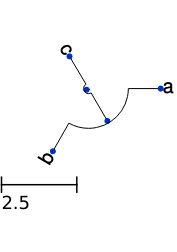

In [43]:
from ete3 import Tree , TreeStyle
t = Tree( "((a,b),c);" )
circular_style = TreeStyle()
circular_style.mode = "c" # draw tree in circular mode
circular_style.scale = 20
t.render("%%inline",w=50, units="mm", tree_style=circular_style)


In [80]:
from ete3 import Tree, TreeStyle
t =  Tree( '((H:0.3,I:0.1):0.5, A:1, (B:0.4,(C:0.5,(J:1.3, (F:1.2, D:0.1):0.5):0.5):0.5):0.5);' )

ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

t.render("%%inline",tree_style=ts)

NameError: name 'ncbi' is not defined

In [65]:
from ete3 import Tree, TreeStyle
with_taskeel = 'with-taskeel' 
without_taskeel ='without-taskeel'
balance = 'balence'
un_balance = 'un-balance'
waited = 'waited'
un_waited = 'un-waited'
lstm = 'Lstm' 
bi_lstm = 'Bi-Lstm' 
gru = 'GRU'
one_hot = 'one-hot' 
binary_8_bit = 'binary 8-bit'
binary_5_bit = 'binary 5-bit'
_2_k_encoding = '2-K'
english = 'English'
arabic = 'Arabic'

tree = """
        (English,);
        
        (Arabic);
        
        """

In [ ]:
encoding = [one_hot,binary_5_bit,binary_8_bit,one_hot,one_hot,one_hot,binary_8_bit,binary_5_bit,binary_8_bit,binary_5_bit]
acc = [99,50,30,45,89,78,45,15,48,35]

source = ColumnDataSource(data=dict(experiments=experiments,
                                    encoding=data.encoding,
                                    acc=data.acc))

tools = []

lstm_plot = figure(x_range=FactorRange(*experiments), plot_height=500, title="LSTM",
           toolbar_location=None,y_range = (0,115), tools=tools)

lstm_plot.vbar(x='experiments',
          top='acc',
          legend="encoding",
          fill_color=factor_cmap('encoding', palette=Spectral6, factors=list(set(encoding))),
          width=0.5 ,
          hover_color="red",
          line_color="green",
          source=source)

lstm_plot.x_range.range_padding = 0.1
lstm_plot.xaxis.major_label_orientation = 1

lstm_plot.xgrid.grid_line_color = None
lstm_plot.legend.orientation = "horizontal"
lstm_plot.legend.location = "top_center"
lstm_plot.xaxis.axis_label = "experiments"
lstm_plot.yaxis.axis_label = "accuracy"
lstm_plot.add_tools(HoverTool(tooltips=[("Acc", "@acc"), ("encoding", "@encoding")]))


bi_lstm_plot = figure(x_range=FactorRange(*experiments) , y_range=(0,115) , plot_height=500, title="Bi-LSTM",
               toolbar_location=None, tools=tools)

bi_lstm_plot.vbar(x='experiments',
                  top='acc',
                  legend="encoding",
             fill_color=factor_cmap('encoding', palette=Spectral6, factors=list(set(encoding))),
             width=0.5 ,
             hover_color="red",
             line_color="green",
             source=source)

bi_lstm_plot.x_range.range_padding = 0.1
bi_lstm_plot.xaxis.major_label_orientation = 1

bi_lstm_plot.xgrid.grid_line_color = None
bi_lstm_plot.legend.orientation = "horizontal"
bi_lstm_plot.legend.location = "top_center"
bi_lstm_plot.xaxis.axis_label = "experiments"
bi_lstm_plot.yaxis.axis_label = "accuracy"
bi_lstm_plot.add_tools(HoverTool(tooltips=[("Acc", "@acc"), ("encoding", "@encoding")]))

show(gridplot([[lstm_plot, bi_lstm_plot]]))